Given a feature vectore X and a quality response Y taking values in the set C, the classification task is to build a function C(X) that takes as input the feature vector X and predicts its value for Y ; i.e. C(X) ∈ C.
Often we are more interested in estimating the **probability*** that X belongs to each category of C

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Data/Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


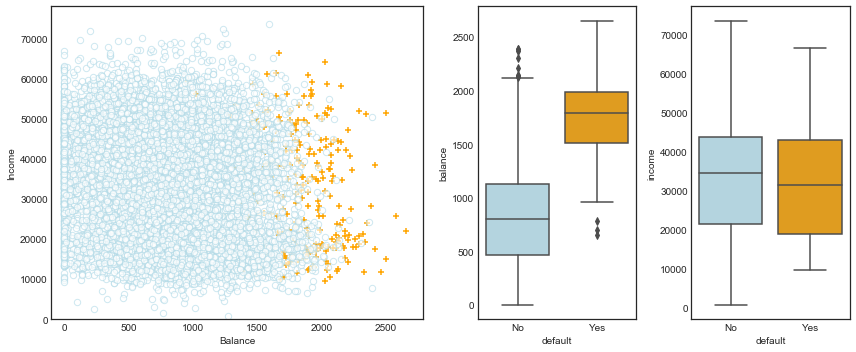

In [5]:
fig = plt.figure(figsize=(12,5))
# The plt.GridSpec() object does not create a plot by itself; 
# it is simply a convenient interface that is recognized by the plt.subplot() command.
grid = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(grid[0,:-2])
ax2 = plt.subplot(grid[0,-2])
ax3 = plt.subplot(grid[0,-1])

ax1.scatter(df[df.default == 'Yes'].balance, df[df.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df[df.default == 'No'].balance, df[df.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
grid.tight_layout(plt.gcf())

In case of binary classification, the task is equivalent to linear discriminant analysis, however, linear regression might produce probabilities less than zero or bigger than one, so Logistic regression is more appropiate.
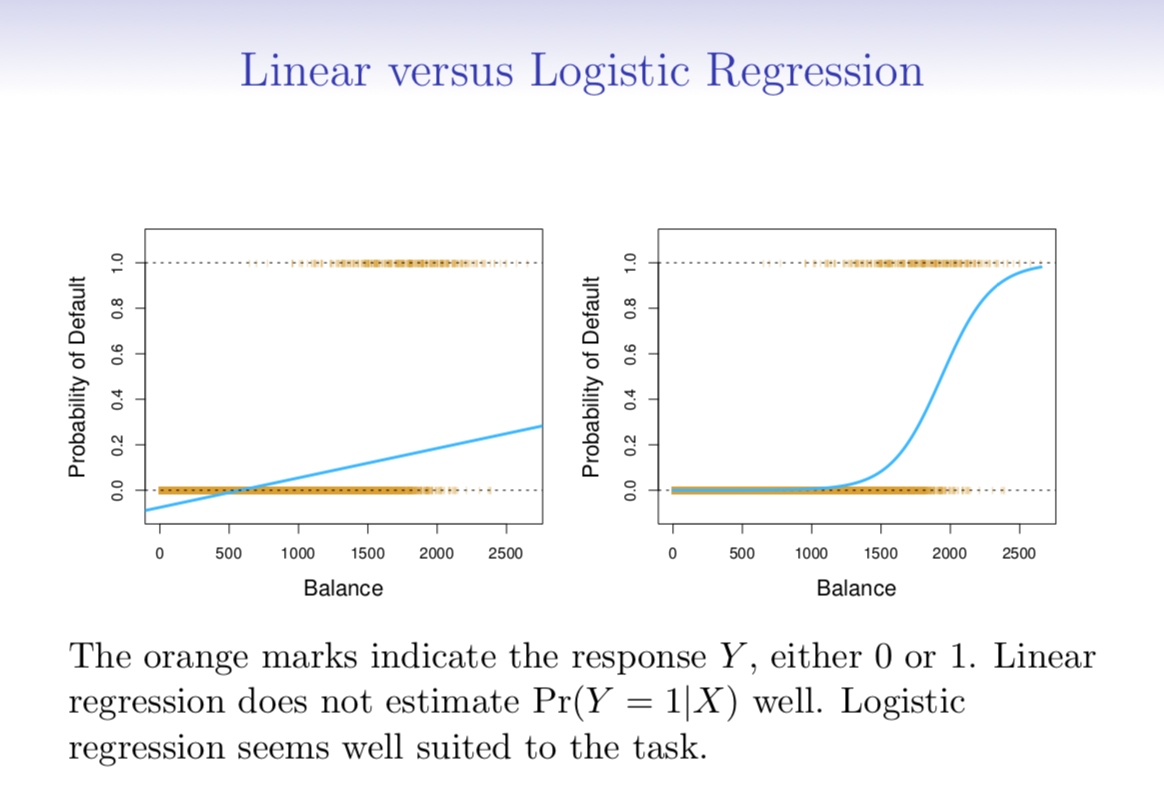

# Logistic regression

$$p(X) = Pr(Y=1/X)=\frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$$

We use **maximum likelihood** to estimate parameters:
$$l(\beta_0,\beta1)=\prod_{i:y_i=1}p(x_i)\prod_{i:y_i=0}(1-p(x_i))$$
The likelihood gives the probability of the observed zeros and ones in the data. We pick parameters to maximize the likelihood
$$\log\left(\frac{p(X)}{1-p(X)}\right)=\beta_0+\beta_1 X$$
 

## Estimating Coefficients


In [20]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
feature_cols = ['balance']
X_train = df[feature_cols]
y = df.default2
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65133006]


/Users/linlin/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/linlin/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [12]:
X_train = sm.add_constant(df.balance)
y = df.default2
est = smf.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [19]:
prob = clf.predict_proba(np.array([1000,2000]).reshape(-1, 1))
print(prob)

[[0.99424785 0.00575215]
 [0.41423066 0.58576934]]


In [23]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


## Logistic regression with several variables

$$p(X) =\frac{e^{\beta_0+\beta_1 X_1 +...+  \beta_p X_p}}{1+e^{\beta_0+\beta_1X_1 +...+  \beta_p X_p}}$$

$$\log\left(\frac{p(X)}{1-p(X)}\right)=\beta_0+\beta_1 X_1 +...+  \beta_p X_p$$

## Case-control sampling and logistic regression
With case control sample(病例对照), the probability of the clases are very unequal, so we can estimate the regression parameter $\beta_j$ accurately but the constant term $\beta_0$ is incorrect 
We can correct the estimated intercept by a simple transformation 
$$ \hat{\beta_0^*} = \hat{\beta_0} + \log \frac{\pi}{1-\pi}-\log \frac{\tilde{\pi}}{1-\tilde{\pi}}$$


In [26]:
data =  pd.read_excel('Data/SAHeartDesease.xls', index_col=0)
print(data.shape)
data.head()

(462, 10)


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


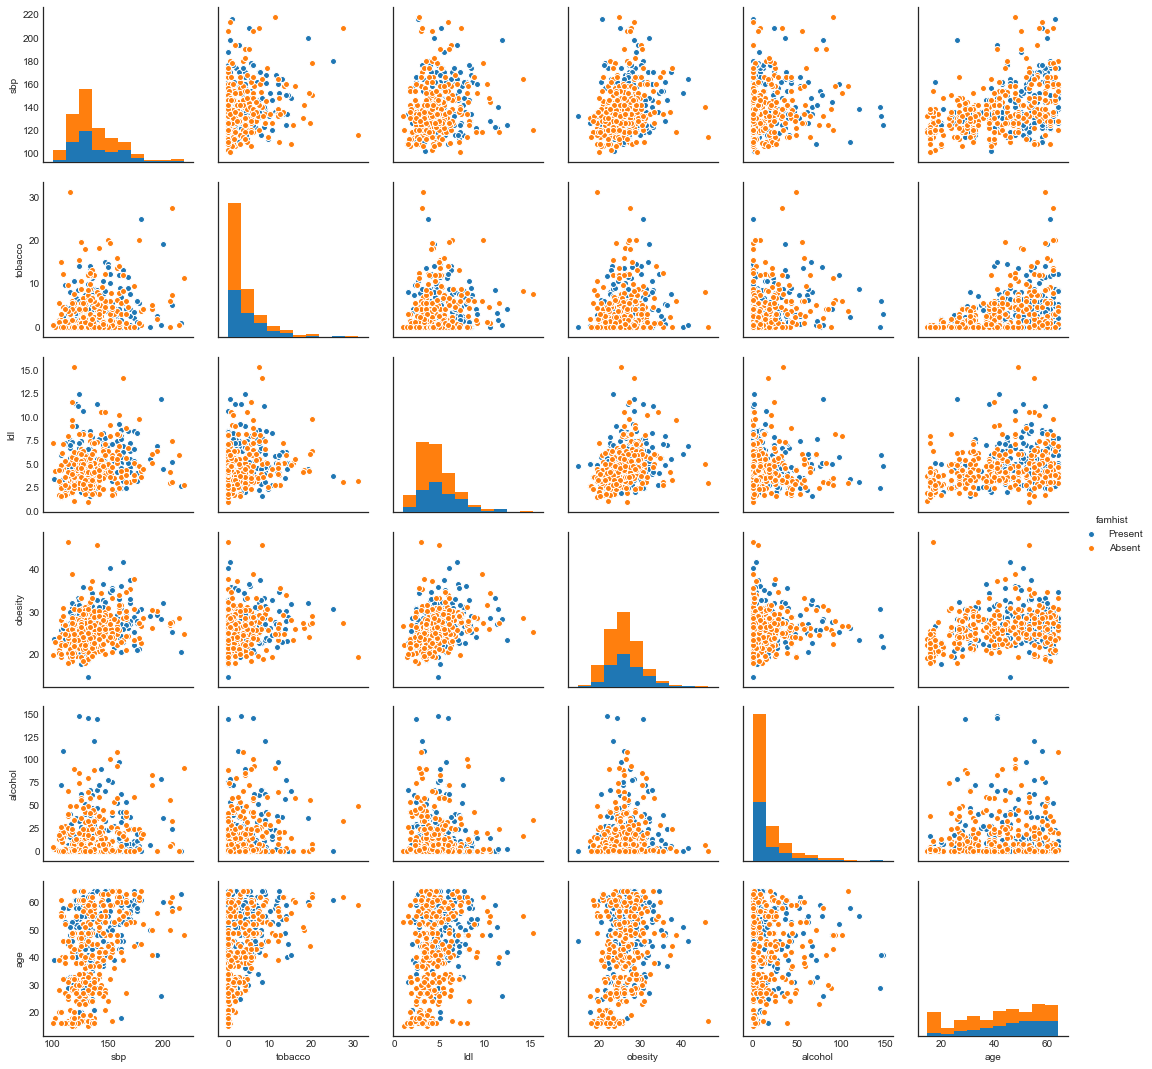

In [28]:
sns.pairplot(data[['sbp','tobacco','ldl','famhist', 'obesity', 'alcohol', 'age']],hue='famhist')

# 4.4 Linear Discriminant analysis
Model the distribution of X in each of the classes separately and then use **Bayes theorem** to flip things around and obtain Pr(Y/X)
$$ Pr(Y=k/X=x)=\frac{Pr(X=x/Y=k)Pr(Y = k)}{Pr(X=x} $$

Writing i n other form for discriminant analysis:
$$ Pr(Y=k/X=x)=\frac{\pi_k f_x(x)}{\sum_{l=1}^k\pi_kf_l(x)} $$
where 
- $f_k(x)$ is the probability density function of X for an observation than comes from the kth class.
- $\pi_k$ is the marginal or prior probability for class k

We classify a new point according to which density is highest, for example, if we have a very unbalanced classes, A and B, if the density of B is higher than A, the new point tends to be classified as B

Estimating $f_k(x)$  is challenging. We refer to $p_k(x)$ as the posterior probability that an observation X = x belongs to the kth class. That is, it is the probability that the observation belongs to the kth class, given the predictor value for that observation.

## Why discriminant analysis?
- Well separated classes lead to unstable parameters with logistic regression. Linear discrimination don't suffer from this problem
- if n is small and the distribution of the X is approximately normal, LDM is more stable
- LDM provides low-dimensional views of data

## 4.4.2 LD analysis when p=1
1 predictor
$f_k(x)$ is normal or gaussian:
$$ f_k(x)=\frac{1}{\sqrt{2\pi \sigma_k}}e^{-0.5(\frac{x-\mu_k}{\sigma_k})^2} $$
where $\mu$ is the mean and $\sigma$ the variance